# SAM

This notebook requires the ViT-B weights file:

    sam_vit_b_01ec64.pth

Download it from Meta AI's official release:

https://github.com/facebookresearch/segment-anything 

Direct download link: https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth 

Place the downloaded file in the root directory of this repository next to `SAM.ipynb`.

In [1]:
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install opencv-python matplotlib torch torchvision

  Cloning https://github.com/facebookresearch/segment-anything.git to c:\users\nh202\appdata\local\temp\pip-req-build-dpa08t0q
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git 'C:\Users\nh202\AppData\Local\Temp\pip-req-build-dpa08t0q'

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: C:\Users\nh202\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: C:\Users\nh202\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [8]:
import os
import glob
import time
import csv
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamPredictor

# --- Setup ---
sam_checkpoint = "sam_vit_b_01ec64.pth"
model_type = "vit_b"
device = "cuda" if torch.cuda.is_available() else "cpu"

# --- Load SAM Model ---
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)

# --- Load image paths ---
image_dir = r"Sample Images"
image_paths = glob.glob(os.path.join(image_dir, "*.png")) + \
              glob.glob(os.path.join(image_dir, "*.jpg")) + \
              glob.glob(os.path.join(image_dir, "*.jpeg"))

# --- Create output subfolder ---
output_dir = os.path.join(image_dir, "SAM_Masks")
os.makedirs(output_dir, exist_ok=True)

# --- Storage ---
timing_data = []
mask_results = []

# --- Iterate through images ---
for img_path in image_paths:
    print(f"Processing {img_path}")

    # Read and convert image
    img_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img_gray is None:
        print(f"Skipping unreadable image: {img_path}")
        continue
    img_rgb = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2RGB)

    # Get dimensions
    h, w = img_gray.shape

    # Foreground: max intensity pixel
    max_loc = np.unravel_index(np.argmax(img_gray, axis=None), img_gray.shape)
    fg_point = [max_loc[1], max_loc[0]]

    # Background anchors
    input_points = np.array([
        fg_point,
        [w // 20, h // 20],
        [w // 20, h - h // 20],
        [w - w // 20, h // 20],
        [w - w // 20, h - h // 20]
    ])
    input_labels = np.array([1, 0, 0, 0, 0])

    # --- Timing + Prediction ---
    predictor.set_image(img_rgb)
    start_time = time.time()
    masks, scores, logits = predictor.predict(
        point_coords=input_points,
        point_labels=input_labels,
        multimask_output=False
    )
    end_time = time.time()

    elapsed_time = end_time - start_time
    timing_data.append({"image": os.path.basename(img_path), "time_sec": elapsed_time})

    # Extract mask
    mask = masks[0].astype(np.uint8) * 255

    # Save mask
    mask_name = f"{os.path.splitext(os.path.basename(img_path))[0]}_SAMmask.png"
    cv2.imwrite(os.path.join(output_dir, mask_name), mask)

    mask_results.append((os.path.basename(img_path), img_gray, mask, input_points, input_labels))

# --- Save timing results ---
csv_path = os.path.join(output_dir, "segmentation_times_SAM.csv")
with open(csv_path, mode="w", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=["image", "time_sec"])
    writer.writeheader()
    writer.writerows(timing_data)

print(f"Timing results saved to {csv_path}")
print(f"Masks saved in {output_dir}")

Processing Sample Images\Image 1.png
Processing Sample Images\Image 2.png
Processing Sample Images\Image 3.png
Processing Sample Images\Image 4.png
Processing Sample Images\Image 5.png
Timing results saved to Sample Images\SAM_Masks\segmentation_times_SAM.csv
Masks saved in Sample Images\SAM_Masks


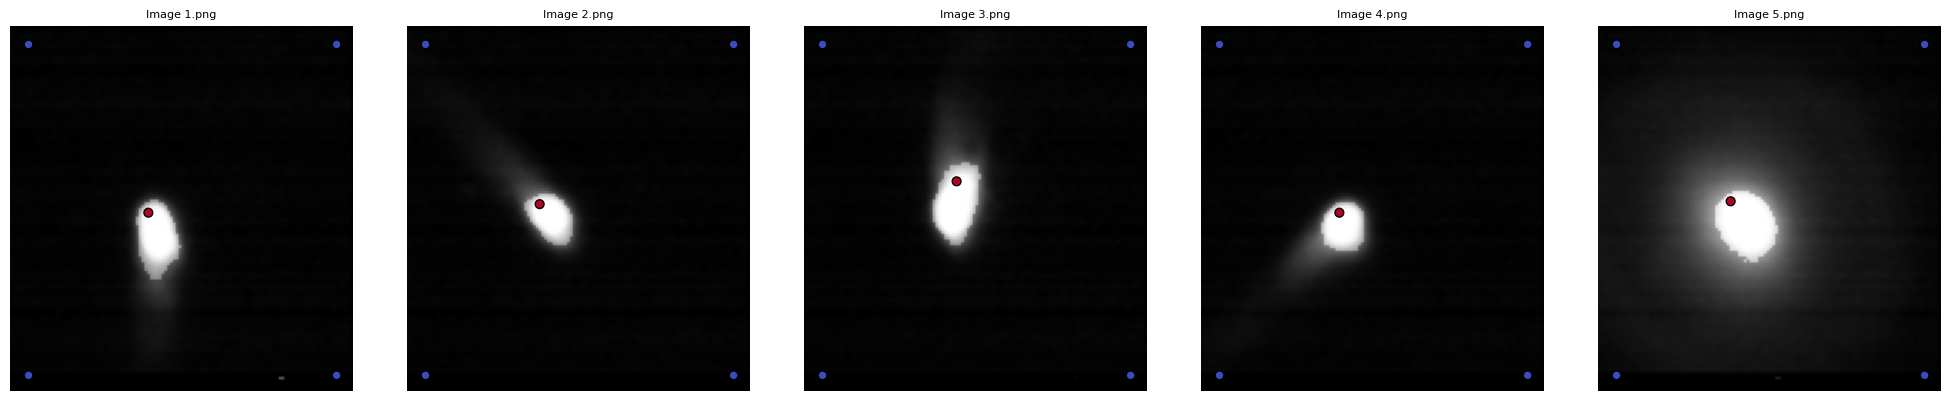

In [17]:
# --- Optional Plotting (outside loop) ---
n_cols = 5
n_images = len(mask_results)
n_rows = (n_images + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
axes = axes.flatten()

for ax, (img_name, img_gray, mask, input_points, input_labels) in zip(axes, mask_results):
    ax.imshow(img_gray, cmap="gray")
    ax.imshow(mask, cmap="gray", alpha=0.25)
    ax.scatter(input_points[:, 0], input_points[:, 1], c=input_labels, cmap="coolwarm", s=40, edgecolors='k')
    ax.set_title(img_name, fontsize=8)
    ax.axis("off")

# Hide unused axes
for ax in axes[len(mask_results):]:
    ax.axis("off")

plt.tight_layout()
plt.show()